In [1]:
from datasets import load_dataset
from datasets import ClassLabel, Audio
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import display, Audio as DisplayAudio
import torch

labels = ["other", "drone"]
SEED = 42
NUM_PROC = 23
SAMPLING_RATE = 16000
CHUNK_DURATION = 0.5
BATCH_SIZE = 32

/home/pierre/Documents/Projects/PST4/AI/.venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load dataset
DS = load_dataset("geronimobasso/drone-audio-detection-samples")

In [3]:
DS = DS["train"]
# Cast labels
DS = DS.cast_column("label", ClassLabel(names=labels))

In [4]:
# Take only n% of the dataset
n = 0.001
dataset = DS.shuffle(seed=SEED).select(range(int(n * len(DS))))

In [5]:
# Cast to 16khz
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

In [6]:
def noise_injection(data, noise_factor):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    # Cast back to the same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

def change_pitch(data, sampling_rate, pitch_factor):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

def time_stretch(data, stretch_factor):
    return librosa.effects.time_stretch(data, rate=stretch_factor)

def time_shift(data, shift_max):
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(data, shift)

def frequency_mask(data, sampling_rate, mask_width=10):
    stft = librosa.stft(data)
    freq_bins = stft.shape[0]
    f0 = np.random.randint(0, freq_bins - mask_width)
    stft[f0:f0+mask_width, :] = 0
    return librosa.istft(stft)

def time_mask(data, mask_width=10):
    d = data.copy()
    t0 = np.random.randint(0, len(d) - mask_width)
    d[t0:t0+mask_width] = 0
    return d

def dynamic_range_compression(data, threshold, ratio):
    # Simple compression: reduce amplitude above threshold
    compressed = data.copy()
    compressed[np.abs(data) > threshold] = threshold + (compressed[np.abs(data) > threshold] - threshold) / ratio
    return compressed


In [7]:
def plot_spectrogram(audio, title, sr=16000):
    D = librosa.amplitude_to_db(
        librosa.stft(audio), ref=np.max
    )
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D, y_axis='log', x_axis='time', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

def plot_waveform(audio, title, sr=16000):
    time = np.linspace(0, len(audio) / sr, num=len(audio))
    plt.figure(figsize=(10, 4))
    plt.plot(time, audio, alpha=0.7)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.grid(True)
    plt.show()

In [8]:
print(f"Size of dataset: {len(dataset)}")

Size of dataset: 180


In [9]:
audio_data = dataset[5]["audio"]["array"]

/tmp/ipykernel_41962/3878890485.py:2: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(


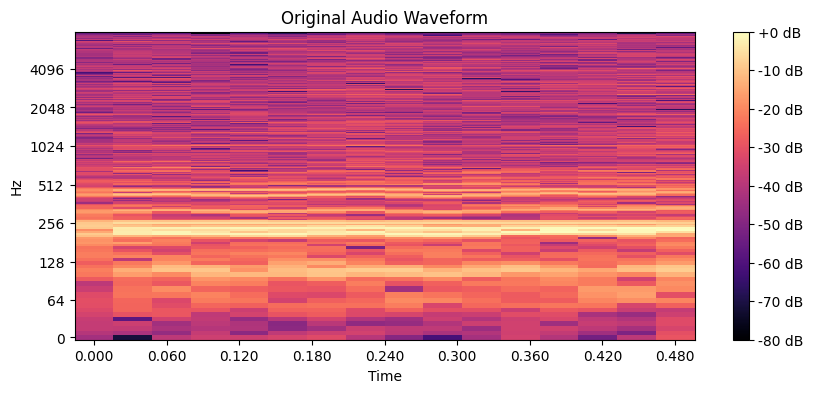

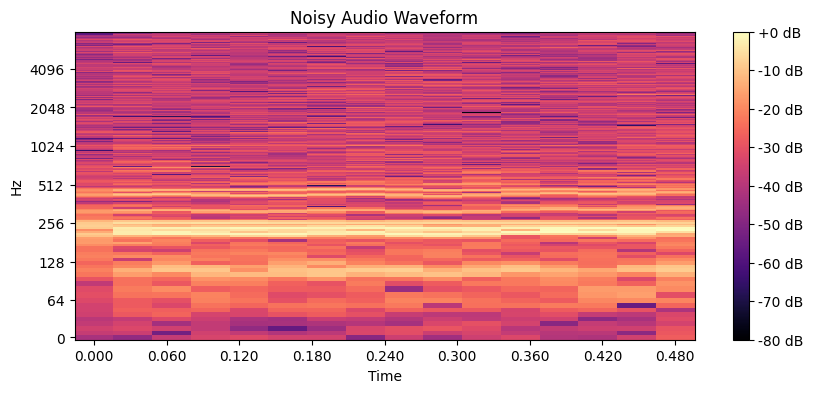

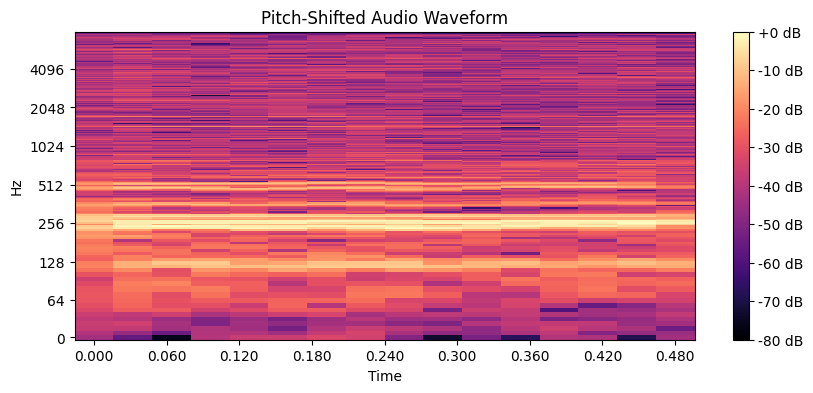

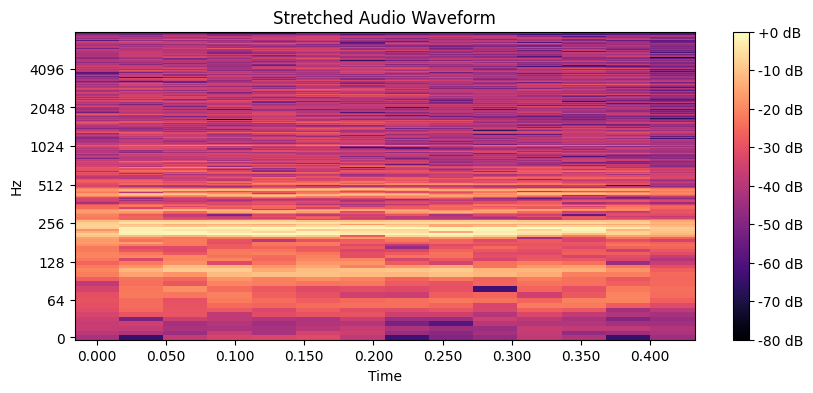

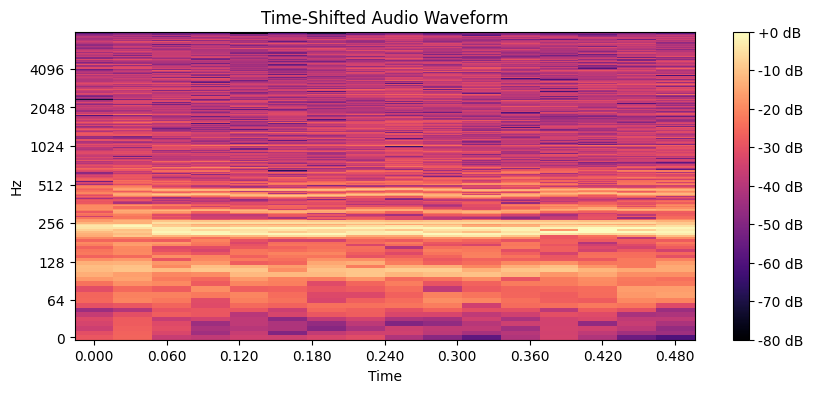

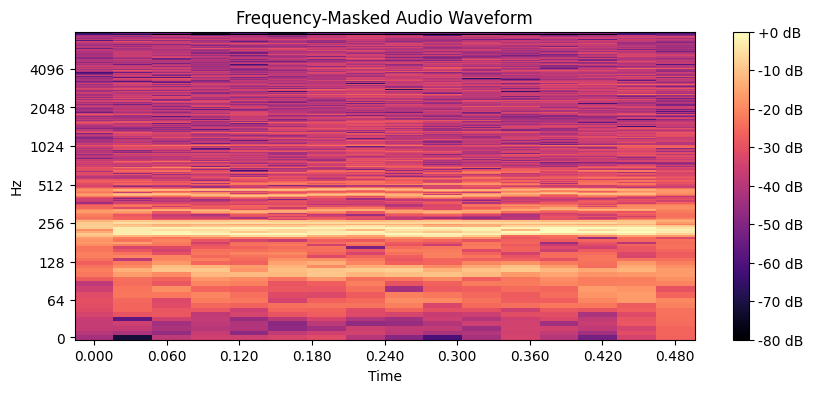

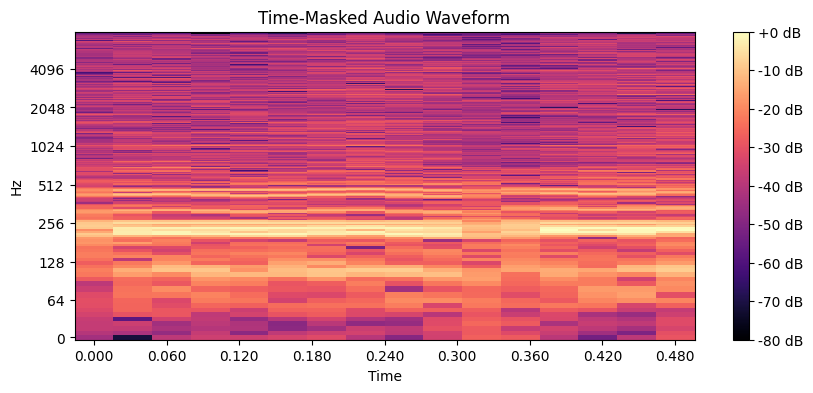

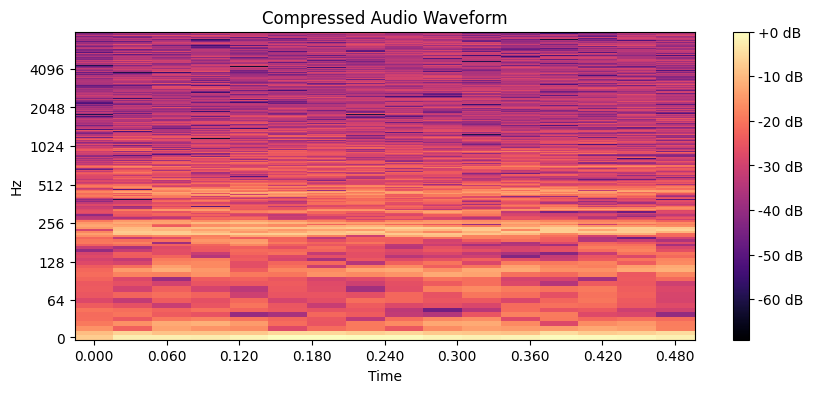

In [10]:
# Apply noise injection
audio_noisy = noise_injection(audio_data, noise_factor=0.03)

# Apply pitch change
audio_pitched = change_pitch(audio_data, 16000, pitch_factor=2)

# Apply time stretch
audio_stretched = time_stretch(audio_data, stretch_factor=1.2)

# Apply time shift
audio_shifted = time_shift(audio_data, shift_max=1000)

# Apply frequency mask
audio_freq_masked = frequency_mask(audio_data, sampling_rate=16000, mask_width=20)

# Apply time mask
audio_time_masked = time_mask(audio_data, mask_width=500)

# Apply dynamic range compression
audio_compressed = dynamic_range_compression(audio_data, threshold=0.1, ratio=4)
# Plot spectrograms
plot_spectrogram(audio_data, "Original Audio Waveform")
plot_spectrogram(audio_noisy, "Noisy Audio Waveform")
plot_spectrogram(audio_pitched, "Pitch-Shifted Audio Waveform")
plot_spectrogram(audio_stretched, "Stretched Audio Waveform")
plot_spectrogram(audio_shifted, "Time-Shifted Audio Waveform")
plot_spectrogram(audio_freq_masked, "Frequency-Masked Audio Waveform")
plot_spectrogram(audio_time_masked, "Time-Masked Audio Waveform")
plot_spectrogram(audio_compressed, "Compressed Audio Waveform")


display(DisplayAudio(audio_data, rate=SAMPLING_RATE))
display(DisplayAudio(audio_noisy, rate=SAMPLING_RATE))
display(DisplayAudio(audio_pitched, rate=SAMPLING_RATE))
display(DisplayAudio(audio_stretched, rate=SAMPLING_RATE))
display(DisplayAudio(audio_shifted, rate=SAMPLING_RATE))
display(DisplayAudio(audio_freq_masked, rate=SAMPLING_RATE))
display(DisplayAudio(audio_time_masked, rate=SAMPLING_RATE))
display(DisplayAudio(audio_compressed, rate=SAMPLING_RATE))

In [11]:
# Split all audio into chunks


def split_audio_into_chunks(audio_array, chunk_duration=CHUNK_DURATION, sampling_rate=SAMPLING_RATE):
    samples_per_chunk = int(chunk_duration * sampling_rate)
    num_chunks = audio_array.shape[-1] // samples_per_chunk

    # Only split into full chunks, no padding
    chunks = [audio_array[i * samples_per_chunk:(i + 1) * samples_per_chunk]
              for i in range(num_chunks)]

    return chunks

def chunk_audio_batch(batch):
    # Process by batch to allow multi processing
    all_audios = []
    all_sampling_rates = []
    all_labels = []

    for audio, label in zip(batch["audio"], batch["label"]):
        audio_array = audio["array"]
        sampling_rate = audio["sampling_rate"]
        audio_array = torch.tensor(audio_array).float()
        chunks = split_audio_into_chunks(audio_array)

        all_audios.extend([chunk.numpy() for chunk in chunks])
        all_sampling_rates.extend([sampling_rate] * len(chunks))
        all_labels.extend([label] * len(chunks))

    return {
        "audio": all_audios,
        "sampling_rate": all_sampling_rates,
        "label": all_labels,
    }

chunked_dataset = dataset.map(
    chunk_audio_batch,
    batched=True,
    num_proc=NUM_PROC,
    batch_size=BATCH_SIZE,
    remove_columns=dataset.column_names,
)
len(chunked_dataset)# Split all audio into chunks


def split_audio_into_chunks(audio_array, chunk_duration=CHUNK_DURATION, sampling_rate=SAMPLING_RATE):
    samples_per_chunk = int(chunk_duration * sampling_rate)
    num_chunks = audio_array.shape[-1] // samples_per_chunk

    # Only split into full chunks, no padding
    chunks = [audio_array[i * samples_per_chunk:(i + 1) * samples_per_chunk]
              for i in range(num_chunks)]

    return chunks

def chunk_audio_batch(batch):
    # Process by batch to allow multi processing
    all_audios = []
    all_sampling_rates = []
    all_labels = []

    for audio, label in zip(batch["audio"], batch["label"]):
        audio_array = audio["array"]
        sampling_rate = audio["sampling_rate"]
        audio_array = torch.tensor(audio_array).float()
        chunks = split_audio_into_chunks(audio_array)

        all_audios.extend([chunk.numpy() for chunk in chunks])
        all_sampling_rates.extend([sampling_rate] * len(chunks))
        all_labels.extend([label] * len(chunks))

    return {
        "audio": all_audios,
        "sampling_rate": all_sampling_rates,
        "label": all_labels,
    }

chunked_dataset = dataset.map(
    chunk_audio_batch,
    batched=True,
    num_proc=NUM_PROC,
    batch_size=BATCH_SIZE,
    remove_columns=dataset.column_names,
)
len(chunked_dataset)

334

In [19]:
for sample in chunked_dataset.select(range(5)):
    print(sample["label"])


1
1
1
1
1
